In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd
import sympy as sym
from odeintw import odeintw
import multitype_new as mt
import importlib
importlib.reload(mt)
from scipy.integrate import odeint

cmp = sns.color_palette('Set2')
sns.set_palette("Set2")

In [26]:
# Parameters to change 
# Change idx to change value of R from Reff_vec - or can choose a different value of R altogether by changing the value of RV
idx = 4
Reff_vec = np.array((2., 2.5, 3., 3.5, 4.))
RV = Reff_vec[idx]

ntypes = 8
# Number of types-at-birth
nexposed = int(ntypes/2)


# Disease Parameters

gamma = 1/7 # Recovery Rate
sigma = 1/3 # Progression rate from exposed to infectious

beta_baseline = RV * gamma
epsilon = 1e-3


# Relative susceptibility for different types 
#sus_ur = 1-0.4 # Susceptibility of unvaccinated, previously infected against new strain
#sus_vu = 1-0.6 # Susceptibility of vaccinated, not previously infected against new strain
#sus_vr = np.min((sus_ur, sus_vu)) # Susceptibility of vaccinated, previously infected against new strain


Tmax = 1000 
num = Tmax 
time = np.linspace(0, Tmax, num=num)
dtime = time[1]-time[0]


# Proportion of population in each type
# p_vac = 0.7
# p_no_vac = 1- p_vac 

# p_rec = 0.2 # % recovered from previous strains
# p_sus = 1-p_rec # % never infected with any coronavirus

# Reduced susceptibility for each type based on infection/vaccine immunity
const_vec = np.squeeze(pd.read_csv('const_vec_in.csv',header=None).to_numpy()) #np.array((1., sus_ur, sus_vu, sus_vr))
prop_vec = np.squeeze(pd.read_csv('prop_vec_in.csv',header=None).to_numpy()) #np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))
scale = const_vec*prop_vec


# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

im = 1
im_vec = np.zeros(ntypes)
y0 = np.zeros(ntypes)
y0[0] = 1
ics = np.zeros(ntypes)
def eta(t):
    return im_vec

# No reduction in transmission conferred by vaccination
trans_vec = np.ones(nexposed)

def lifetime_vec(beta, gamma, sigma, ntypes = ntypes, const_vec = const_vec, prop_vec = prop_vec, trans_vec = trans_vec):
    nexposed = int(ntypes / 2)
    omega_vec = sigma * np.ones(ntypes) 

        
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta)*trans_vec[nex] + gamma
    return omega_vec

omega_vec = lifetime_vec(beta_baseline, gamma, sigma)

# num_sims = 10000
# G_df = pd.read_csv('Gillespie_times_epsilon=0.001.csv').to_numpy()

# G_test = np.zeros((len(Reff_vec), num_sims))#
# for i in range(len(Reff_vec)):
#     G_test[i, :] = G_df[i, 1:]


In [27]:
save = True
plot = True
# Plotting Parameters
showplot = 100
showplot_rho = 300

In [28]:


def P(u, t): # Offspring distribution

        ## Returns a vector of length ntypes with entry i containing  probabilities of generating particles 
        ## of each type from a particle of type i

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_baseline) + gamma)
        

        sum_gen_funcs = np.sum((beta_baseline*prop_vec/omega)*const_vec*u[:nexposed])
         
        for nex in range(0, nexposed):

            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs  + (gamma/omega)
        
        return pvec  

def Jacobian_mat(beta, gamma, sigma, ntypes = ntypes, const_vec = const_vec, prop_vec = prop_vec, trans_vec = trans_vec, omega_vec = omega_vec):
    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)       
    nexposed = int(ntypes/2)
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta)*trans_vec[nex] + gamma
        Omat[nex, nex+nexposed] = omega_vec[nex]
        Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta *trans_vec[nex]
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta * prop_vec)*trans_vec[nex]

    Omat -= np.diag(omega_vec)
    return Omat



## Extinction Probability

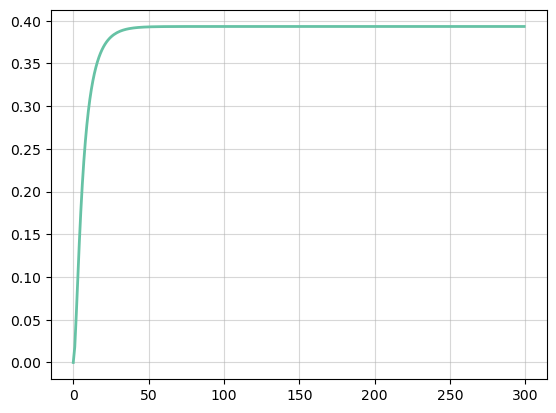

In [29]:

rho = (odeint(mt.set_odes, ics, time, args = (P, omega_vec)).T )
q = np.ones_like(time)
for i in range(ntypes):
    q *= rho[i, :] ** y0[i]
if plot:
    plt.grid(alpha = 0.5)
    plt.plot(time[:showplot_rho], q[:showplot_rho], lw=2, label = str(np.round(RV, 2)))

if save:
    np.savetxt('./Outputs_for_matlab/p_extinction/p_extinction_R=' + str(RV) + '.csv', np.vstack((time, q)))



## Mean

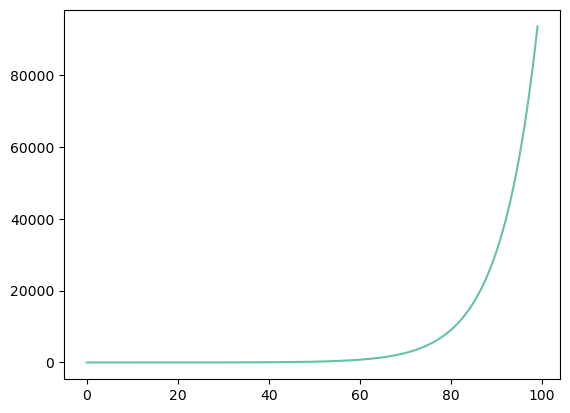

In [30]:
# Jacobian, or mean matrix
Omat = Jacobian_mat(beta_baseline, gamma, sigma)
# Mean of each type
Mmat = odeint(mt.set_mean_odes, y0, time, args = (Omat,)).T
# Total mean
mean = np.sum(Mmat, axis=0)
plt.plot(mean[:100])


## Variance and T* calculation

[ 0.12269408 -0.33333333 -0.59888456 -0.33333333 -0.33333333 -0.14285714
 -0.14285714 -0.14285714]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.61it/s]


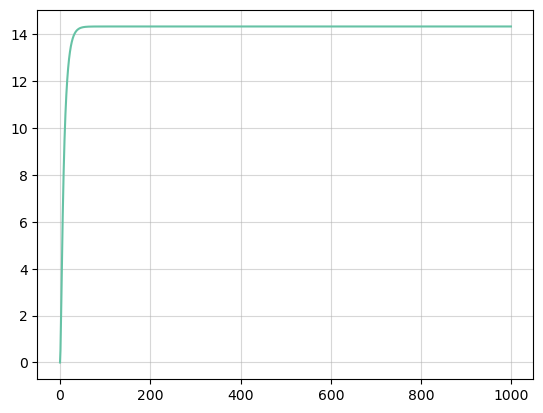

In [31]:
variance = mt.variance(time, y0, omega_vec, Omat, [prop_vec, const_vec, beta_baseline, gamma], eta)

#Coefficient of variation
sig_over_mean = (np.sqrt(variance)/(mean))
if plot:
    plt.grid(alpha = 0.5)
    plt.plot(sig_over_mean)
if save:
    np.savetxt('./Outputs_for_matlab/mean_variance/mean_variance_R=' + str(RV) + '.csv', np.vstack((time, mean, variance)))

In [32]:
Tstar_idx, Tstar = mt.Tstar(time, q, sig_over_mean, thresh1 = epsilon, thresh2 = epsilon)
Zstar_min= mean[Tstar_idx]
Tstar, Zstar_min

(62.06206206206207, 994.1573933248148)

In [33]:
eigvls, orth = nla.eig(Omat)
ordering = (np.argsort(eigvls)).tolist()
eigvls, orth = mt.reorder_evecs(eigvls, orth, ordering)
diagmat = np.diag(eigvls)
growth_rate = np.max(eigvls)
assert(growth_rate > 0), 'Growth Rate must be positive (i.e. Branching Process must be supercritical)'

orth_inv = mt.invert_mat_safe(orth.copy())
orth_c = orth.copy().T
orthc_inv = mt.invert_mat_safe(orth_c.copy())


### Build variance matrix via Kronecker Products
H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c)) 
Amat = np.kron(orthc_inv, orthc_inv)
Amat_inv = np.kron(orth_c, orth_c)

vec_w = np.zeros(ntypes**3)

# Build Hessian matrix
Hessian_mat = np.zeros((ntypes, ntypes, ntypes))
for level in range(0, nexposed):
    for i in range(0, nexposed):

        Hessian_mat[level + nexposed, level+nexposed, i] = (beta_baseline * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
        Hessian_mat[level + nexposed, i, level+nexposed] = (beta_baseline * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

P_mat = np.zeros((ntypes, ntypes))


for nex in range(0, nexposed):
    P_mat[nex, nex+nexposed] = omega_vec[nex]/omega_vec[nex]
    P_mat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_baseline/omega_vec[nex+nexposed]
    P_mat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_baseline * prop_vec)/omega_vec[nex+nexposed]

P_mat = P_mat.T

Gmat = np.zeros((ntypes, ntypes, ntypes))
C = np.zeros(ntypes**3)
blorg = np.zeros((ntypes, ntypes))
for l in range(0, ntypes):
    f_vec = (P_mat - np.identity(ntypes))[l, :]
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1

    Gmat[l, :, :] = Hessian_mat[l, :, :] - np.diag(P_mat[:, l]) #- np.outer(P_mat[:, l], P_mat[:, l])
    Gmat[l, :, :] += np.diag(unitvec)        
    Gmat[l, :, :] *= omega_vec[l]
        

## Feller Diffusion

- Returns: A vector of eigenvalues (first of these is the growth rate) and a matrix of eigenvectors (the first column is the dominant eigenvector) 
- Also, the inverse of the matrix of eigenvectors, P^-1 - we need the first column of this as a scaling to recover prevalence X from eigenvector V


In [40]:
print(beta_baseline)
print(evec)

0.5714285714285714
[0.29505591 0.29505591 0.29505591 0.29505591 0.40366076 0.40366076
 0.40366076 0.40366076]


In [38]:
eigvls, orth = nla.eig(Omat)
growth_rate = np.max(eigvls)
print(growth_rate)

change_from_ebasis = -orth # P
evec = change_from_ebasis[:, 0]

change_to_ebasis = mt.invert_mat_safe(change_from_ebasis)
xi = change_to_ebasis[:, 0]
variance_diffusion_mat = np.zeros((ntypes, ntypes))
for l in range(ntypes):
    variance_diffusion_mat += change_from_ebasis@(change_from_ebasis)@(Gmat[l, :, :] * xi[l])
    

variance_all = nla.norm(variance_diffusion_mat[0, :])
print(variance_all)
evec_scaling = 1/np.sum(xi)

xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))
xvec_idx = np.min(np.where(xvec>=(evec_scaling*Zstar_min))[0])
integral_limit = xvec[xvec_idx]

## Save growth rate, variance and scaling factor
if save:
    np.savetxt('./Outputs_for_matlab/FPT_params_R=' + str(RV) + '.csv', np.array((growth_rate, variance_all, evec_scaling, integral_limit, beta_baseline)))
    np.savetxt('./Outputs_for_matlab/dominant_eigenvector_R=' + str(RV) + '.csv', evec)
    np.savetxt('./Outputs_for_matlab/Jacobian_R=' + str(RV) + '.csv', pd.DataFrame(Omat))


0.12269408039326357
0.08696887053198485


## Run Feller Diffusion


In [55]:
t0 = 0
dt = np.diff(time)[0]

# stop_cases = [50, int(Istars_min[-1])]
stop_cases = [50, int(Zstar_min)]
cols = [str(st) for st in stop_cases]


def chi_sq(u, x, t):
    x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
    lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
    chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
    return chi_sq_pdf



# xvec_idx = np.min(np.where(xvec>=blorg)[0])
print(xvec[xvec_idx])
cdf_chisq = np.zeros(len(time))

for T_idx, T_val in enumerate(tqdm(time)):
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T_val,)).flatten() 
    prob =  (1-(chi_sq_integral[xvec_idx]))
    cdf_chisq[T_idx] = prob
    
pdf_chisq = np.gradient(cdf_chisq, dt)



685.8068580685807


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\dysonl\AppData\Local\Temp\ipykernel_21212\2219801841.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  x_scale = 2*growth_rate*x/(((variance_all/2))*(np.exp(growth_rate*t) - 1))
C:\Users\dysonl\AppData\Local\Temp\ipykernel_21212\2219801841.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  lamb = 2*growth_rate*np.exp(growth_rate*t)/((variance_all/2)*(np.exp(growth_rate*t) - 1))
C:\Users\dysonl\AppData\Local\Temp\ipykernel_21212\2219801841.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  chi_sq_pdf = growth_rate/((variance_all/2)*(np.exp(growth_rate*t) - 1)) * np.sqrt(np.exp(growth_rate*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
C:\Users\dysonl\AppData\Local\Temp\ipykernel_21212\2219801841.py:12: RuntimeWarning: invalid value encountered in s

(0.0, 200.0)

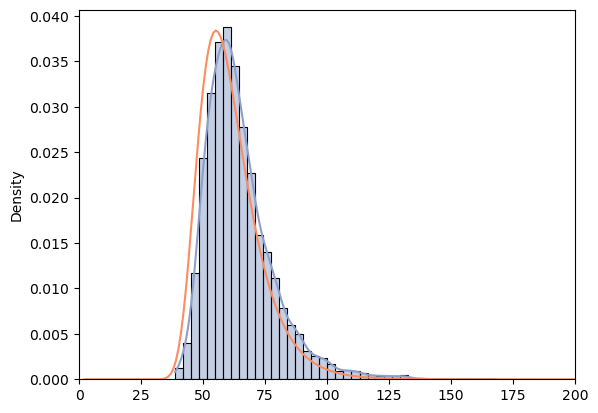

In [27]:
sns.histplot(G_test[idx, :], stat = 'density', kde = True, bins = 40, label = 'Gillespie', 
             alpha =0.5, color = cmp[2])
plt.plot(time, pdf_chisq, label = "Feller_exact", color = cmp[1])
plt.xlim([0, 200])